# Fine-tuning con LoRA de F2LLM 4B

## Importar librerías

In [1]:
import matplotlib.pyplot as plt
from torch import nn
import pandas as pd
import numpy as np
import torch
import os


from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    auc
)

from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
from datasets import Dataset

from pyevall.evaluation import PyEvALLEvaluation
from pyevall.metrics.metricfactory import MetricFactory

## Configuración y parámetros

In [ ]:
os.environ["HF_TOKEN"] = "poner_algo"

MODEL_NAME = "codefuse-ai/F2LLM-4B"
MAIN_PATH = ".."
GROUP_ID = "BeingChillingWeWillWin"

TEXT_COLUMN = "text_clean" 
LABEL_COLUMN = "task1"

DATA_TRAIN_PATH = os.path.join(MAIN_PATH, "preprocessed_data", "train_preprocessed_v2.json")
DATA_VAL_PATH = os.path.join(MAIN_PATH, "preprocessed_data", "val_preprocessed_v2.json")
DATA_TEST_PATH = os.path.join(MAIN_PATH, "preprocessed_data", "test_preprocessed_v2.json")

OUTPUT_DIR = os.path.join(MAIN_PATH, "results_v2", "F2LLM-4B", TEXT_COLUMN)
LOGGING_DIR = os.path.join(MAIN_PATH, "results_v2", "F2LLM-4B", f"{TEXT_COLUMN}_logs")
SAVE_PATH = os.path.join(MAIN_PATH, "results_v2", "F2LLM-4B", f"{TEXT_COLUMN}_lora")
PREDICTIONS_DIR = os.path.join(MAIN_PATH, "results_v2", "F2LLM-4B", "predictions")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)
os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(LOGGING_DIR, exist_ok=True)

## Carga y preprocesamiento de datos

In [3]:
train_df = pd.read_json(DATA_TRAIN_PATH)
val_df = pd.read_json(DATA_VAL_PATH)
test_df = pd.read_json(DATA_TEST_PATH)

label_map = {"NO": 0, "YES": 1}
label_map_inverse = {0: "NO", 1: "YES"}

train_df["label"] = train_df[LABEL_COLUMN].map(label_map)
val_df["label"] = val_df[LABEL_COLUMN].map(label_map)

test_df["label"] = -1  # Placeholder

print(f"Text column used: {TEXT_COLUMN}")
print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")
print(f"\nDistribución de etiquetas en TRAIN:")
print(train_df[LABEL_COLUMN].value_counts())
print(f"\nDistribución de etiquetas en VAL:")
print(val_df[LABEL_COLUMN].value_counts())

Text column used: text_clean
Train size: 5154 | Val size: 910 | Test size: 934

Distribución de etiquetas en TRAIN:
task1
NO     2862
YES    2292
Name: count, dtype: int64

Distribución de etiquetas en VAL:
task1
NO     505
YES    405
Name: count, dtype: int64


## Tokenización y preparación del dataset

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize(batch):
    encoding = tokenizer(batch[TEXT_COLUMN], truncation=True, padding="max_length", max_length=256)
    return encoding

train_dataset = Dataset.from_pandas(train_df[['id_EXIST', TEXT_COLUMN, 'label']]).map(tokenize, batched=True)
eval_dataset = Dataset.from_pandas(val_df[['id_EXIST', TEXT_COLUMN, 'label']]).map(tokenize, batched=True)
test_dataset = Dataset.from_pandas(test_df[['id_EXIST', TEXT_COLUMN, 'label']]).map(tokenize, batched=True)

Map:   0%|          | 0/5154 [00:00<?, ? examples/s]

Map:   0%|          | 0/910 [00:00<?, ? examples/s]

Map:   0%|          | 0/934 [00:00<?, ? examples/s]

## Métricas de entrenamiento y configuración

In [5]:
# compute_metrics: sigmoid >= 0.5 en vez de argmax
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits shape: [batch, 1] o [batch] — aplanamos
    logits_tensor = torch.tensor(logits).squeeze(-1)
    probs = torch.sigmoid(logits_tensor).numpy()
    preds = (probs >= 0.5).astype(int)

    # Si las etiquetas son placeholder (-1), no calculamos métricas reales
    if labels is None or (hasattr(labels, '__iter__') and any(l < 0 for l in labels)):
        return {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# num_labels=1 → una sola salida (logit escalar) + sigmoid en el loss
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1,
    problem_type="single_label_classification"
)

if model.config.pad_token_id is None:
    model.config.pad_token_id = tokenizer.pad_token_id

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

class BinaryTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").float()
        outputs = model(**inputs)
        logits = outputs.logits.squeeze(-1)
        loss_fn = nn.BCEWithLogitsLoss()
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

Qwen3ForSequenceClassification LOAD REPORT from: codefuse-ai/F2LLM-4B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


trainable params: 5,900,800 || all params: 4,028,371,456 || trainable%: 0.1465


## Entrenamiento

In [6]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=5,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_dir=LOGGING_DIR,
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy="epoch",
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    bf16=True,
    lr_scheduler_type="cosine"
)

trainer = BinaryTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.379239,0.404476,0.816484,0.869565,0.691358,0.770289
2,0.246108,0.448332,0.842857,0.811905,0.841975,0.826667
3,0.242075,0.724429,0.829670,0.847222,0.753086,0.797386
4,0.029017,0.793310,0.832967,0.823529,0.795062,0.809045
5,0.032594,0.824238,0.824176,0.814910,0.782716,0.798489


('../results/F2LLM-4B/text_clean_lora/tokenizer_config.json',
 '../results/F2LLM-4B/text_clean_lora/chat_template.jinja',
 '../results/F2LLM-4B/text_clean_lora/tokenizer.json')

## Inferencia en DEV y determinación del mejor threshold

AUC (DEV): 0.9211
Mejor Threshold (DEV): 0.4815
TPR en mejor threshold: 0.8543
FPR en mejor threshold: 0.1584

Métricas en DEV con threshold óptimo (0.4815):
Accuracy: 0.8473
Precision: 0.8122
Recall: 0.8543
F1-Score: 0.8327


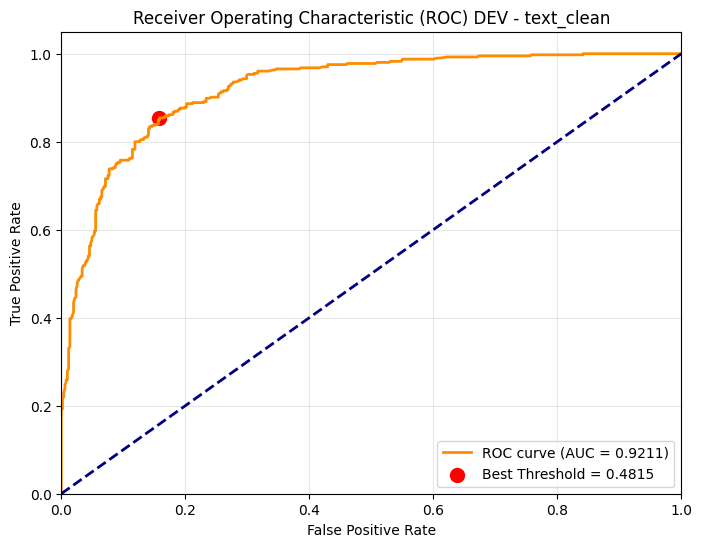

In [7]:
dev_predictions = trainer.predict(eval_dataset)

dev_logits = torch.tensor(dev_predictions.predictions).squeeze(-1)
y_probs_dev = torch.sigmoid(dev_logits).numpy()
y_true_dev = dev_predictions.label_ids

fpr, tpr, thresholds = roc_curve(y_true_dev, y_probs_dev)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"AUC (DEV): {roc_auc:.4f}")
print(f"Mejor Threshold (DEV): {optimal_threshold:.4f}")
print(f"TPR en mejor threshold: {tpr[optimal_idx]:.4f}")
print(f"FPR en mejor threshold: {fpr[optimal_idx]:.4f}")

dev_preds_optimal = (y_probs_dev >= optimal_threshold).astype(int)
precision_opt, recall_opt, f1_opt, _ = precision_recall_fscore_support(
    y_true_dev, dev_preds_optimal, average='binary', zero_division=0
)
acc_opt = accuracy_score(y_true_dev, dev_preds_optimal)

print(f"\nMétricas en DEV con threshold óptimo ({optimal_threshold:.4f}):")
print(f"Accuracy: {acc_opt:.4f}")
print(f"Precision: {precision_opt:.4f}")
print(f"Recall: {recall_opt:.4f}")
print(f"F1-Score: {f1_opt:.4f}")

# Pintar figura de la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red',
            label=f'Best Threshold = {optimal_threshold:.4f}', s=100)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) DEV - {TEXT_COLUMN}')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Evaluación en DEV con PyEvALL

In [8]:
dev_preds_for_pyevall = []
for idx, (id_exist, pred) in enumerate(zip(val_df['id_EXIST'].values, dev_preds_optimal)):
    dev_preds_for_pyevall.append({
        'test_case': 'EXIST2025',
        'id': str(id_exist),
        'value': label_map_inverse[pred]
    })

dev_preds_df = pd.DataFrame(dev_preds_for_pyevall)
dev_preds_path = os.path.join(PREDICTIONS_DIR, 'dev_predictions_temp_clean.json')
with open(dev_preds_path, 'w', encoding='utf-8') as f:
    f.write(dev_preds_df.to_json(orient='records'))

dev_gold = []
for idx, (id_exist, label) in enumerate(zip(val_df['id_EXIST'].values, val_df[LABEL_COLUMN].values)):
    dev_gold.append({
        'test_case': 'EXIST2025',
        'id': str(id_exist),
        'value': label
    })

dev_gold_df = pd.DataFrame(dev_gold)
dev_gold_path = os.path.join(PREDICTIONS_DIR, 'dev_gold_temp_clean.json')
with open(dev_gold_path, 'w', encoding='utf-8') as f:
    f.write(dev_gold_df.to_json(orient='records'))

test = PyEvALLEvaluation()
metrics = [
    MetricFactory.Accuracy.value,
    MetricFactory.FMeasure.value,
]
params = dict()
report = test.evaluate(dev_preds_path, dev_gold_path, metrics, **params)
print("\n=== Evaluación en DEV con PyEvALL ===")
report.print_report()

2026-02-24 17:52:12,144 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['Accuracy', 'FMeasure']


2026-02-24 17:52:12,195 - pyevall.metrics.metrics - INFO -             evaluate() - Executing accuracy evaluation method


2026-02-24 17:52:12,318 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method



=== Evaluación en DEV con PyEvALL ===
{
  "metrics": {
    "Accuracy": {
      "name": "Accuracy",
      "acronym": "Acc",
      "description": "Coming soon!",
      "status": "OK",
      "results": {
        "test_cases": [{
          "name": "EXIST2025",
          "average": 0.8472527472527472
        }],
        "average_per_test_case": 0.8472527472527472
      }
    },
    "FMeasure": {
      "name": "F-Measure",
      "acronym": "F1",
      "description": "Coming soon!",
      "status": "OK",
      "results": {
        "test_cases": [{
          "name": "EXIST2025",
          "classes": {
            "NO": 0.8594539939332659,
            "YES": 0.832731648616125
          },
          "average": 0.8460928212746954
        }],
        "average_per_test_case": 0.8460928212746954
      }
    }
  },
  "files": {
    "dev_predictions_temp_clean.json": {
      "name": "dev_predictions_temp_clean.json",
      "status": "OK",
      "gold": false,
      "description": "Use parameter: repo

## Inferencia en TEST y generación de predicciones finales

In [9]:
test_predictions = trainer.predict(test_dataset)

test_logits = torch.tensor(test_predictions.predictions).squeeze(-1)
y_probs_test = torch.sigmoid(test_logits).numpy()

test_preds = (y_probs_test >= optimal_threshold).astype(int)

print(f"\nPredicciones en TEST (con threshold={optimal_threshold:.4f}):")
print(f"Total muestras: {len(test_preds)}")
print(f"Predicciones YES: {np.sum(test_preds == 1)} ({100*np.mean(test_preds == 1):.2f}%)")
print(f"Predicciones NO: {np.sum(test_preds == 0)} ({100*np.mean(test_preds == 0):.2f}%)")


Predicciones en TEST (con threshold=0.4815):
Total muestras: 934
Predicciones YES: 460 (49.25%)
Predicciones NO: 474 (50.75%)


## Guardar predicciones en formato PyEvALL para TEST

In [10]:

MODEL_ID = "f2llm4Bclean"

test_preds_for_submission = []
for idx, (id_exist, pred) in enumerate(zip(test_df['id_EXIST'].values, test_preds)):
    test_preds_for_submission.append({
        'test_case': 'EXIST2025',
        'id': str(id_exist),
        'value': label_map_inverse[pred]
    })

test_preds_df = pd.DataFrame(test_preds_for_submission)

output_filename = f"{GROUP_ID}_{MODEL_ID}.json"
output_path = os.path.join(PREDICTIONS_DIR, output_filename)

with open(output_path, 'w', encoding='utf-8') as output_file:
    output_file.write(test_preds_df.to_json(orient='records'))

print(f"\nPredicciones guardadas en: {output_path}")


Predicciones guardadas en: ../results/F2LLM-4B/predictions/BeingChillingWeWillWin_f2llm4Bclean.json
